In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import os

from tqdm.notebook import tqdm

In [7]:
data_fold = "../../../data/carla_sim/random_spawn"

In [43]:
WIDTH, HEIGHT = 640, 480

N_SUBDIV_X = 2
N_SUBDIV_Y = 2
SUBDIV_WIDTH, SUBDIV_HEIGHT = WIDTH // N_SUBDIV_X, HEIGHT // N_SUBDIV_Y
N_DISCARD_TOP = 1
N_DISCARD_BOTTOM = 1
N_DISCARD_LEFT = 1
N_DISCARD_RIGHT = 1

T_STEPS = 180

In [32]:
class Net(nn.Module):
    def __init__(
        self,
        width=SUBDIV_WIDTH,
        height=SUBDIV_HEIGHT,
        kern_half_size=3,
        sigm_kern=0.3,
        reg=1.5,
        size_layers=[10],
    ):
        super().__init__()

        self.width = width
        self.height = height
        self.kern_half_size = kern_half_size
        self.size_layers = (
            size_layers if isinstance(size_layers, list) else [size_layers]
        )
        self.kern_size = 2 * kern_half_size + 1

        self.sigm_kern = sigm_kern

        self.reg = reg

        _x, _y = np.meshgrid(
            np.arange(-kern_half_size, kern_half_size + 1),
            np.arange(-kern_half_size, kern_half_size + 1),
        )

        self.kern_x = nn.Conv2d(
            1, 1, self.kern_size, padding=kern_half_size, bias=False
        )

        self.kern_y = nn.Conv2d(
            1, 1, self.kern_size, padding=kern_half_size, bias=False
        )

        self.kern_norm = nn.Conv2d(
            1, 1, self.kern_size, padding=kern_half_size, bias=False
        )

        _gauss = np.exp(-(_x**2 + _y**2) / (2.0 * (sigm_kern * kern_half_size) ** 2))
        _gauss /= _gauss.sum()

        self.kern_norm.weight.data = torch.tensor(_gauss).float().unsqueeze(0).unsqueeze(0)
        self.kern_x.weight.data = torch.tensor(_x * _gauss).float().unsqueeze(0).unsqueeze(0)
        self.kern_y.weight.data = torch.tensor(_y * _gauss).float().unsqueeze(0).unsqueeze(0)

        _x, _y = np.meshgrid(
            np.linspace(-1, 1, width), np.linspace(-height/width, height/width, height)
        )

        self.wx = nn.Parameter(torch.tensor(_x).float().unsqueeze(0).unsqueeze(0))
        self.wy = nn.Parameter(torch.tensor(_y).float().unsqueeze(0).unsqueeze(0))

        self.layers = []

        self.layers.append(nn.Flatten())

        if len(size_layers) > 0:
            for i in range(len(size_layers)):
                if i == 0:
                    self.layers.append(nn.Linear(width * height, size_layers[i]))
                else:
                    self.layers.append(nn.Linear(size_layers[i - 1], size_layers[i]))
                self.layers.append(nn.ReLU())
            self.layers.append(nn.Linear(size_layers[-1], 1))
        else:
            self.layers.append(nn.Linear(width * height, 1))

        self.layers = nn.Sequential(*self.layers)
    
    def forward(self, x):

        x_p = (x > 0).float()
        x_n = (x < 0).float()

        I_x_p_prev = self.kern_x(x_p[...,0:1,:,:])
        I_y_p_prev = self.kern_y(x_p[...,0:1,:,:])
        I_norm_p_prev = self.kern_norm(x_p[...,0:1,:,:])

        vx_p = -x_p[...,1:2,:,:] * I_x_p_prev / (self.reg + I_norm_p_prev)
        vy_p = -x_p[...,1:2,:,:] * I_y_p_prev / (self.reg + I_norm_p_prev)

        I_x_n_prev = self.kern_x(x_n[...,0:1,:,:])
        I_y_n_prev = self.kern_y(x_n[...,0:1,:,:])
        I_norm_n_prev = self.kern_norm(x_n[...,0:1,:,:])

        vx_n = -x_n[...,1:2,:,:] * I_x_n_prev / (self.reg + I_norm_n_prev)
        vy_n = -x_n[...,1:2,:,:] * I_y_n_prev / (self.reg + I_norm_n_prev)

        vx = vx_p + vx_n
        vy = vy_p + vy_n

        v_project = vx * self.wx + vy * self.wy

        return self.layers(v_project)

In [5]:
def load_raw_data(fold):
    samples = [f for f in os.listdir(fold) if f.startswith("example")]
    samples.sort(key=lambda x: int(x.split("_")[1]))

    labels = []
    metadata = []
    data = []

    mem_gb = 0

    for sample in samples:
        events = np.load(os.path.join(fold, sample, "events.npy"))
        metadat = np.load(os.path.join(fold, sample, "sim_data.npz"), allow_pickle=True)

        labels.append(int(metadat["coll_type"] != "none"))

        data.append(events)

        mem_gb += events.nbytes / 1e9
        print(f"Total estimate of event data size: {mem_gb:.2f} GB", end="\r")

        metadata.append(
            {
                "coll_type": metadat["coll_type"][()],
                "t_end_ms": metadat["t_end"][()],
                "dt": metadat["dt"][()],
                "vel": metadat["vel"][()],
                "diam": metadat["diameter_object"][()],
            }
        )
    
    return data, labels, metadata

In [8]:
raw_data, raw_labels, raw_metadata = load_raw_data(data_fold)

In [10]:
def convert_to_tens(data, labels, metadata, t_steps):
    X = []

    idx_drop = []
    for i, events in tqdm(enumerate(data)):
        dt = metadata[i]["dt"]
        t_end = metadata[i]["t_end_ms"]
        nt = int(t_end / dt)
        if nt < t_steps:
            idx_drop.append(i)
            print(f"Sample {i} has too few frames, dropping it.")
            continue
        _dat = torch.zeros(t_steps, SUBDIV_HEIGHT, SUBDIV_WIDTH).type(torch.int8)
        for t in tqdm(range(t_steps), leave=False):
            _evts = events[
                (events["t"] >= (t + nt - t_steps) * dt)
                & (events["t"] < (t + 1 + nt - t_steps) * dt)
                & (events["y"] >= N_DISCARD_TOP * SUBDIV_HEIGHT // 2)
                & (events["y"] < HEIGHT - N_DISCARD_BOTTOM * SUBDIV_HEIGHT // 2)
                & (events["x"] >= N_DISCARD_LEFT * SUBDIV_WIDTH // 2)
                & (events["x"] < WIDTH - N_DISCARD_RIGHT * SUBDIV_WIDTH // 2)
            ]
            _dat[
                t,
                _evts["y"] - N_DISCARD_TOP * SUBDIV_HEIGHT // 2,
                _evts["x"] - N_DISCARD_LEFT * SUBDIV_WIDTH // 2,
            ] = torch.tensor(2 * _evts["p"].astype(int) - 1).type(torch.int8)
        X.append(_dat)

    X = torch.stack(X)

    labels = torch.tensor([labels[i] for i in range(len(labels)) if i not in idx_drop]).type(torch.int8)
    metadata = [metadata[i] for i in range(len(metadata)) if i not in idx_drop]

    return X, labels, metadata
    

In [11]:
X, Y, metadata = convert_to_tens(raw_data, raw_labels, raw_metadata, T_STEPS)

0it [00:00, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Sample 29 has too few frames, dropping it.


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Sample 129 has too few frames, dropping it.
Sample 130 has too few frames, dropping it.


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Sample 134 has too few frames, dropping it.


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Sample 194 has too few frames, dropping it.


  0%|          | 0/180 [00:00<?, ?it/s]

Sample 196 has too few frames, dropping it.


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

In [25]:
try:
    torch.save(X, "X.pt")
    torch.save(Y, "Y.pt")
    torch.save(metadata, "metadata.pt")
except:
    print("Could not save tensors.")

In [21]:
def gen_x_sequ(X, Y):
    _t_steps = X.shape[1]
    X_1 = X[:,1:,...]
    X_0 = X[:,:-1,...]
    X_seq = torch.stack([X_0, X_1], dim=2)
    X_seq = X_seq.view(-1, X_seq.shape[-3], X_seq.shape[-2], X_seq.shape[-1])
    
    Y_expand = Y.unsqueeze(1).repeat(1,_t_steps-1).flatten()

    return X_seq, Y_expand

In [22]:
X_seq, Y_seq = gen_x_sequ(X, Y)

In [24]:
X_seq.shape, Y_seq.shape

(torch.Size([34905, 2, 240, 320]), torch.Size([34905]))

In [26]:
try:
    torch.save(X_seq, "X_seq.pt")
    torch.save(Y_seq, "Y_seq.pt")
except:
    print("Could not save tensors.")

In [29]:
n_samples = X_seq.shape[0]

# split data into training and test set
n_train = int(0.8 * n_samples)
n_test = n_samples - n_train

idx = torch.randperm(n_samples)

X_train = X_seq[idx[:n_train]]
X_test = X_seq[idx[n_train:]]

Y_train = Y_seq[idx[:n_train]]
Y_test = Y_seq[idx[n_train:]]

In [35]:
# create dataloaders

train_data = torch.utils.data.TensorDataset(X_train, Y_train)
test_data = torch.utils.data.TensorDataset(X_test, Y_test)

BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = Net(kern_half_size=5, sigm_kern=0.3, reg=50.0, size_layers=[])
net.to(device)

Net(
  (kern_x): Conv2d(1, 1, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5), bias=False)
  (kern_y): Conv2d(1, 1, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5), bias=False)
  (kern_norm): Conv2d(1, 1, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5), bias=False)
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=76800, out_features=1, bias=True)
  )
)

In [37]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

N_EPOCHS = 5

train_losses = []

for epoch in range(N_EPOCHS):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = loss_fn(outputs.flatten(), labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    print(f"Epoch {epoch + 1}, loss: {running_loss / len(train_loader)}")

Epoch 1, loss: 0.24621747978637581
Epoch 2, loss: 0.05767000201230235
Epoch 3, loss: 0.01756755789769344
Epoch 4, loss: 0.0085487894731906
Epoch 5, loss: 0.0030357889204471163


In [38]:
# test the model

net.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)

        predicted = (outputs > 0).int()[:,0]

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the test set: {100 * correct / total}%")

Accuracy of the network on the test set: 94.08394212863486%


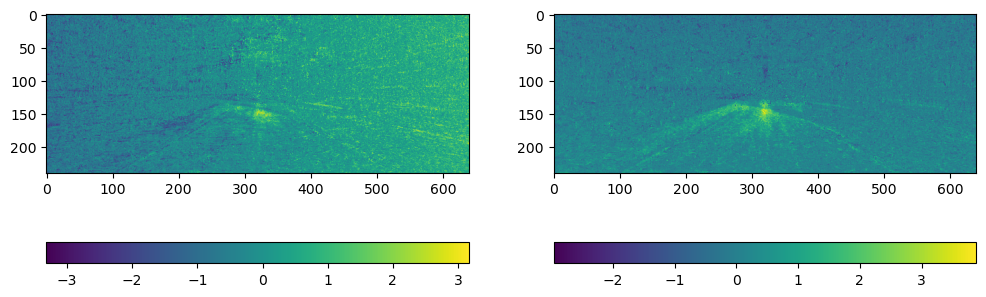

In [158]:
net.eval()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

img0 = ax[0].imshow(net.wx.detach().cpu().numpy().squeeze())
plt.colorbar(img0, ax=ax[0], orientation="horizontal")

img1 = ax[1].imshow(net.wy.detach().cpu().numpy().squeeze())
plt.colorbar(img1, ax=ax[1], orientation="horizontal")

plt.show()

193
0


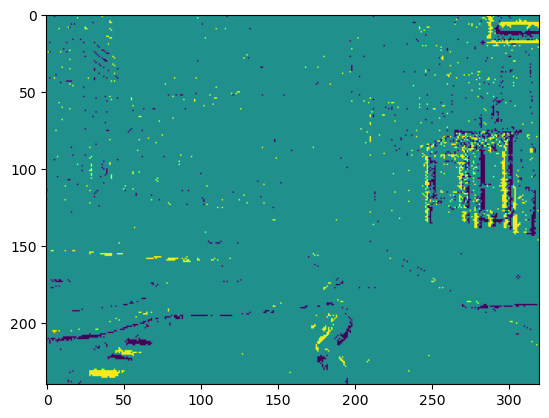

In [69]:
while True:
    sample = np.random.randint(0, X.shape[0])
    if Y[sample] == 0:
        break

print(sample)

plt.imshow(X[sample,130,:,:].detach().numpy())
print(Y[sample].detach().cpu().numpy())
plt.show()

In [70]:
net.eval()
out = np.zeros((T_STEPS-1))
_o = 0.0
with torch.no_grad():
    for k in range(T_STEPS-1):
        img = torch.stack([X[sample,k+1,...], X[sample,k,...]], dim=0).float().to(device)
        #for i in range(_evts.shape[0]):
        _o = 0.95 * _o + 0.05 * (1. + np.tanh(0.5 * net(img).detach().cpu().numpy()[:,0])) / 2.
        out[k] = _o

/tmp/ipykernel_1097243/1474229134.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[k] = _o


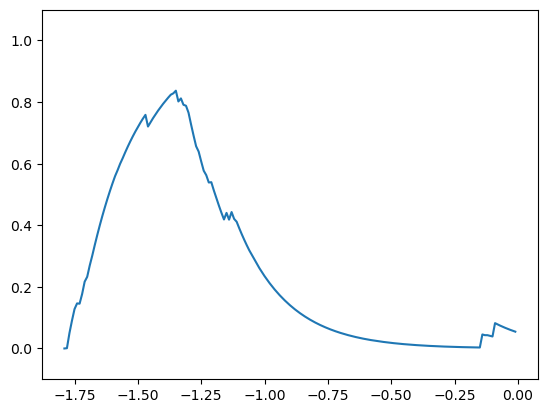

In [71]:
t_ax = np.arange(1-T_STEPS,0) * metadata[sample]["dt"] / 1000
plt.plot(t_ax, out)
plt.ylim(-.1,1.1)
plt.show()